In [ ]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import fbprophet
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.linear_model import LinearRegression

In [ ]:
pd.options.display.max_rows=100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
products = pd.read_csv('/content/drive/MyDrive/project1/products.csv')
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [ ]:
del products['product_name_lenght'], products['product_description_lenght'], products['product_photos_qty']
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0


In [ ]:
products['product_volume_cm3'] = products.product_length_cm*products.product_height_cm*products.product_width_cm
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0
...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0,64000.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0,4864.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0,5103.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0,8060.0


In [ ]:
#количество уникальных продуктов
products.product_id.nunique()

32951

In [ ]:
products.isna().sum()

product_id                 0
product_category_name    610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
product_volume_cm3         2
dtype: int64

Проверим, стоит ли товары с отсутствующей категорией (Other) разбивать еще на несколько категорий, сравнив среднее и среднеквадратическое отклонение в этой категории с данными характеристиками других категорий

In [ ]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'mean'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
dvds_blu_ray,1746.854167
telefonia,1865.841270
livros_importados,1935.387097
livros_tecnicos,2758.991870
relogios_presentes,3470.398044
livros_interesse_geral,3900.046296
fashion_bolsas_e_acessorios,4480.634865
fashion_underwear_e_moda_praia,4584.132075
audio,4970.172414


In [ ]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'std'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
livros_importados,1206.736803
pc_gamer,1620.278165
telefonia,2023.848886
dvds_blu_ray,2896.124152
livros_tecnicos,3084.661858
livros_interesse_geral,3503.460753
fashion_roupa_infanto_juvenil,3800.294752
relogios_presentes,4020.254201
flores,4789.929803


In [ ]:
products.fillna({'product_category_name':'Other'}, inplace=True)

In [ ]:
order_items = pd.read_csv('/content/drive/MyDrive/project1/order_items.csv', parse_dates=[4])
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [ ]:
order_items.product_id.nunique()

32951

In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/project1/orders.csv', parse_dates=['order_approved_at'])
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
full_data = pd.merge(order_items, orders.loc[:, ['order_id', 'order_approved_at']], on='order_id', how='left')
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32


In [ ]:
full_data = pd.merge(full_data, products, on='product_id', how='left')
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0


In [ ]:
full_data.product_category_name.nunique()

74

In [ ]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0


In [ ]:
full_data['Index'] = range(len(full_data))

In [ ]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,Index
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0,0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0,2
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0,3
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0,112645
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0,112646
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0,112647
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0,112648


Посчитаем количество продаж конкретных товаров

In [ ]:
product_sells = full_data.groupby(['product_id']).agg({'Index':'count'}).sort_values(by='Index')
product_sells.head(100)

,Index
product_id,
00066f42aeeb9f3007548bb9d3f33c38,1
911e26785862f450cf2240fc5168f83d,1
911cfb37438b7fa9ad54535990178868,1
911b8d269dbaa6c005b23d04e1c7fcbc,1
9117307cf75efa6e964d697f0d1297f9,1
9116d72465bec45e9931216018aa5b2d,1
9116ce8acab686803dfd443f5963e69c,1
9116a056deb0f453c4f5611141deedc5,1
91103cf73f3a0e72896573d8f2271e17,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001886729BCD0>]],
      dtype=object)

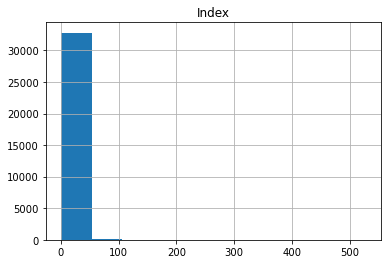

In [ ]:
product_sells.hist()

Основная масса товаров продается меньше 50 раз

In [ ]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,Index
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35,cool_stuff,650.0,28.0,9.0,14.0,3528.0,0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13,pet_shop,30000.0,50.0,30.0,40.0,60000.0,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0,2
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18,perfumaria,200.0,16.0,10.0,15.0,2400.0,3
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-25 04:11:01,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0,112645
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-17 04:31:48,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0,112646
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-24 17:14:25,esporte_lazer,967.0,21.0,24.0,19.0,9576.0,112647
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-15 00:04:32,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0,112648


In [ ]:
full_data = full_data.loc[:, ['product_id', 'order_approved_at']]
full_data = full_data.sort_values(by='order_approved_at')
full_data

,product_id,order_approved_at
84389,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
84390,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
84391,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
14027,33430c5c1027d812b5c62f778e5ee7f7,2016-10-04 09:43:32
44782,9c7bdf67b06b419aefb93cfdfc96c55d,2016-10-04 10:18:57
...,...,...
60815,2c2b6a28924791234bd386bddb17512e,NaT
85300,5ab02ca028398131a5ae91401eb49788,NaT
94630,cae2e38942c8489d9d7a87a3f525c06b,NaT
94999,02a79d79e818ad0be36cfc843a6af7ad,NaT


In [ ]:
full_data.isna().sum()

product_id            0
order_approved_at    15
dtype: int64

In [ ]:
full_data.dropna(inplace=True)

Отберем товары, которые продавались больше 1 раза

In [ ]:
not_new_prod_id = full_data.groupby('product_id', as_index=False).agg('count')
not_new_prod_id = not_new_prod_id[not_new_prod_id.order_approved_at > 1]
not_new_prod_id = not_new_prod_id.product_id
not_new_prod_id

3        000b8f95fcb9e0096488278317764d19
6        00126f27c813603687e6ce486d909d01
7        001795ec6f1b187d37335e1c4704762e
9        001b72dfd63e9833e8c02742adf472e3
11       00210e41887c2a8ef9f791ebc780cc36
                       ...               
32937    ffedbd68fa6f44e788ff6c2db8094715
32938    ffef256879dbadcab7e77950f4f4a195
32939    fff0a542c3c62682f23305214eaeaa24
32943    fff6177642830a9a94a0f2cba5e476d1
32946    fffdb2d0ec8d6a61f0a0a0db3f25b441
Name: product_id, Length: 14831, dtype: object

In [ ]:
full_data = full_data[full_data.product_id.isin(not_new_prod_id)]
full_data

,product_id,order_approved_at
84389,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
84390,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
84391,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15 12:16:38
44782,9c7bdf67b06b419aefb93cfdfc96c55d,2016-10-04 10:18:57
104571,29bedbfbe73ea473396306b4f0c010ec,2016-10-04 10:25:46
...,...,...
9829,bdcf6a834e8faa30dac3886c7a58e92e,2018-08-29 14:30:23
4924,2b4472df15512a2825ae86fd9ae79335,2018-08-29 14:31:07
4925,2b4472df15512a2825ae86fd9ae79335,2018-08-29 14:31:07
23530,d04857e7b4b708ee8b8b9921163edba3,2018-08-29 15:10:26


In [ ]:
full_data.order_approved_at = full_data.order_approved_at.dt.date
full_data

,product_id,order_approved_at
84389,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15
84390,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15
84391,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15
44782,9c7bdf67b06b419aefb93cfdfc96c55d,2016-10-04
104571,29bedbfbe73ea473396306b4f0c010ec,2016-10-04
...,...,...
9829,bdcf6a834e8faa30dac3886c7a58e92e,2018-08-29
4924,2b4472df15512a2825ae86fd9ae79335,2018-08-29
4925,2b4472df15512a2825ae86fd9ae79335,2018-08-29
23530,d04857e7b4b708ee8b8b9921163edba3,2018-08-29


In [ ]:
prod_id_sells = full_data.groupby(['product_id', 'order_approved_at']).agg({'order_approved_at':'count'})
prod_id_sells = prod_id_sells.rename({'order_approved_at':'sells_val'}, axis='columns')
prod_id_sells.reset_index(level='order_approved_at', inplace = True)
prod_id_sells.reset_index(inplace=True)
prod_id_sells

,product_id,order_approved_at,sells_val
0,000b8f95fcb9e0096488278317764d19,2018-08-01,1
1,000b8f95fcb9e0096488278317764d19,2018-08-10,1
2,00126f27c813603687e6ce486d909d01,2017-09-17,2
3,001795ec6f1b187d37335e1c4704762e,2017-10-28,1
4,001795ec6f1b187d37335e1c4704762e,2017-11-25,1
...,...,...,...
76368,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-04-03,1
76369,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-04-19,1
76370,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-05-01,1
76371,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-07,1


In [ ]:
prods = prod_id_sells.product_id.value_counts().index

Заполним месяца, в которых не было продаж товара, нулями

In [ ]:
series = dict()
for prod_id in prods:
    one_prod_sells = prod_id_sells[prod_id_sells.product_id == prod_id].reset_index(drop=True)
    one_prod_sells_list = np.array([])
    one_prod_sells_list = np.append(one_prod_sells_list, one_prod_sells.loc[0, 'sells_val'])
    for i in range(1, len(one_prod_sells)):
        diff = (one_prod_sells.iloc[i, 1] - one_prod_sells.iloc[(i-1), 1]).days
        try:
            zero = np.zeros(diff-1)
            one_prod_sells_list = np.append(one_prod_sells_list, zero)
        except:
            pass
        one_prod_sells_list = np.append(one_prod_sells_list, one_prod_sells.loc[i, 'sells_val'])
    
    series[prod_id] = one_prod_sells_list

In [ ]:
len(series)

14831

Отеберем товары, которые продавались больше 2 месяцев, для того, чтобы ипользовать последний месяц в качестве тест-выборки

In [ ]:
# Создадим словарь для продуктов, которые продавались меньше 60 дней
series_unpopular_product = dict()

In [ ]:
for k in series.copy():
    if len(series[k]) < 60:
        series_unpopular_product[k] = series[k]
        del series[k]

In [ ]:
len(series)

9072

### Словарь с необходимыми временными рядами

In [ ]:
series

{'99a4788cb24856965c36a24e339b6058': array([2., 1., 1., 0., 1., 2., 2., 0., 0., 1., 1., 1., 0., 2., 0., 0., 2.,
        0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 1., 0., 0.,
        1., 3., 1., 2., 2., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 2., 3.,
        0., 1., 4., 1., 1., 3., 1., 1., 1., 1., 0., 3., 1., 3., 1., 2., 0.,
        1., 3., 0., 2., 0., 3., 5., 3., 2., 3., 2., 1., 1., 1., 3., 1., 3.,
        0., 1., 0., 2., 4., 2., 2., 4., 1., 1., 0., 0., 7., 2., 1., 1., 4.,
        0., 1., 1., 0., 3., 3., 0., 1., 1., 3., 2., 0., 3., 1., 4., 0., 1.,
        2., 1., 5., 2., 1., 1., 1., 3., 1., 3., 4., 2., 2., 3., 2., 2., 3.,
        3., 5., 3., 2., 1., 1., 3., 1., 1., 2., 0., 1., 1., 2., 0., 4., 1.,
        1., 1., 1., 0., 3., 1., 0., 0., 4., 1., 3., 4., 1., 0., 1., 0., 2.,
        1., 2., 3., 2., 0., 1., 2., 0., 0., 2., 0., 1., 1., 0., 0., 0., 2.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 1., 0., 1., 1., 1., 1., 4.,
        3., 0., 1., 2., 0., 0., 2., 0., 0., 0., 0., 

In [ ]:
series_unpopular_product

{'e7cc48a9daff5436f63d3aad9426f28b': array([ 2.,  1.,  1.,  1.,  2.,  4.,  2.,  5.,  4.,  5.,  4.,  6.,  1.,
         1.,  6.,  2., 14., 18.,  1.,  3.,  3.,  2.,  0.,  1.,  1.,  2.,
         0.,  0.,  0.,  1.]),
 'd6160fb7873f184099d9bc95e30376af': array([1., 3., 3., 1., 2., 3., 1., 0., 2., 2., 1., 2., 0., 0., 0., 0., 1.,
        0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 2., 0., 1., 1., 1.]),
 '73326828aa5efe1ba096223de496f596': array([1., 1., 3., 1., 1., 3., 2., 1., 0., 3., 2., 2., 5., 2., 3., 0., 8.,
        5., 1., 2., 2., 0., 2., 1., 3.]),
 'b1d207586fca400a2370d50a9ba1da98': array([1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 2., 8., 5., 2., 1., 2., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 6., 4., 0., 1., 0., 0., 4.]),
 '9aa9caee155847cddb376a05b9a39791': array([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1.

## Прогнозирование

Выберем конкретный SKU для прогнозирования

In [ ]:
SKU = input('Введите SKU для прогнозирования: ')  

Введите SKU для прогнозирования: 99a4788cb24856965c36a24e339b6058


In [ ]:
SKU_sells = prod_id_sells[prod_id_sells.product_id == SKU]
SKU_sells

,product_id,order_approved_at,sells_val
45621,99a4788cb24856965c36a24e339b6058,2017-02-28,2
45622,99a4788cb24856965c36a24e339b6058,2017-03-01,1
45623,99a4788cb24856965c36a24e339b6058,2017-03-02,1
45624,99a4788cb24856965c36a24e339b6058,2017-03-04,1
45625,99a4788cb24856965c36a24e339b6058,2017-03-05,2
...,...,...,...
45899,99a4788cb24856965c36a24e339b6058,2018-08-05,1
45900,99a4788cb24856965c36a24e339b6058,2018-08-06,1
45901,99a4788cb24856965c36a24e339b6058,2018-08-13,2
45902,99a4788cb24856965c36a24e339b6058,2018-08-14,2


In [ ]:
first_sale = SKU_sells.order_approved_at.min()
last_sale = SKU_sells.order_approved_at.max()

In [ ]:
if SKU in series_unpopular_product:
    
    unpop_dates_list = []
    for i in range(1, 22): # Создаем последовательность дат на 21 день с момента последней продажи продукта
        unpop_dates_list.append(last_sale + relativedelta(days=+i))
        
    lm = LinearRegression()
    lm.fit(np.arange(1,len(series_unpopular_product[SKU]) + 1).reshape(-1, 1), series_unpopular_product[SKU])
    lm_predictions = lm.predict(np.arange(len(series_unpopular_product[SKU]) + 1, len(series_unpopular_product[SKU]) + 1 + 21).reshape(-1, 1))
    lm_predictions = np.where(lm_predictions >= 0, lm_predictions, 0)
    predictions = pd.DataFrame({'Date':unpop_dates_list, 'Prediction':lm_predictions})
    predictions = predictions[7:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи
    print(predictions)
    exit()

Создадим помесячную последовательноть дат для SKU 

In [ ]:
dates_list = []
for i in range(len(series[SKU])):
    dates_list.append(first_sale + relativedelta(days=+i))

In [ ]:
SKU_df = pd.DataFrame({'date':dates_list, 'sells_val':series[SKU]})
SKU_df.columns = ['ds', 'y']
SKU_df

,ds,y
0,2017-02-28,2.0
1,2017-03-01,1.0
2,2017-03-02,1.0
3,2017-03-03,0.0
4,2017-03-04,1.0
...,...,...
534,2018-08-16,0.0
535,2018-08-17,0.0
536,2018-08-18,0.0
537,2018-08-19,0.0


Отберем последний месяц продаж товара в качестве тестовой выборки

In [ ]:
SKU_train_df = SKU_df.iloc[:-30,]
SKU_test_df = SKU_df.iloc[-30:,]

### Prophet

In [ ]:
params_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
grid = ParameterGrid(params_grid)

In [ ]:
errors = np.ndarray([])
for p in grid:
    m = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, uncertainty_samples=False)
    m.fit(SKU_train_df)
    predictions = m.predict(SKU_test_df.drop(['y'], axis=1))
    predictions = predictions.loc[:,['ds', 'yhat']]
    predictions.yhat = predictions.yhat.where(predictions.yhat>=0, 0)
    errors = np.append(errors, mean_absolute_percentage_error(SKU_test_df.y, predictions.yhat))

In [ ]:
models_MSE = dict()
p = grid[errors.argmin()]
fb_model = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, uncertainty_samples=False)
fb_model.fit(SKU_train_df)
predictions = fb_model.predict(SKU_test_df.drop(['y'], axis=1))
predictions = predictions.loc[:,['ds', 'yhat']]
predictions.yhat = predictions.yhat.where(predictions.yhat>=0, 0)
models_MSE['fb_model'] = mean_absolute_percentage_error(SKU_test_df.y, predictions.yhat)

### Экспоненциальное сглаживание 

In [ ]:
train = SKU_train_df.set_index('ds')
train.index = pd.to_datetime(train.index)
train = train.asfreq('d')
exp_sm_model = ExponentialSmoothing(train)
exp_sm_predictions = exp_sm_model.fit().forecast(30)
models_MSE['exp_sm'] = mean_absolute_percentage_error(SKU_test_df.y, exp_sm_predictions)

### Наивная модель

In [ ]:
naive_predictions = np.ones(len(SKU_test_df))*SKU_train_df.y.mean()
models_MSE['naive_model'] = mean_absolute_percentage_error(SKU_test_df.y, naive_predictions)

In [ ]:
models_MSE = pd.DataFrame.from_dict(models_MSE, orient='index', columns=['MAPE'])
models_MSE = models_MSE.sort_values(by='MAPE')

Сравнение моделей по метрике MAE

In [ ]:
models_MSE

,MAPE
fb_model,2.653890e-01
exp_sm,7.846571e+14
naive_model,3.101497e+15


Построение окончательного прогноза с помощью найлучшей модели на полных данных

In [ ]:
if models_MSE.iloc[0,:].name == 'fb_model':
    print('Making predictions with Prophet model')
    fb_model = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, uncertainty_samples=False)
    fb_model.fit(SKU_df)
    future = fb_model.make_future_dataframe(periods=21, include_history=False)
    predictions = fb_model.predict(future)
    predictions.yhat = predictions.yhat.where(predictions.yhat>=0, 0)
    predictions = predictions.loc[:,['ds', 'yhat']]
    predictions = predictions[7:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи
    predictions.columns = ['Date', 'Prediction']
    
elif models_MSE.iloc[0,:].name == 'exp_sm':
    print('Making predictions with Exponential Smoothing model')
    train = SKU_df.set_index('ds')
    train.index = pd.to_datetime(train.index)
    train = train.asfreq('d')
    exp_sm_model = ExponentialSmoothing(train)
    exp_sm_predictions = exp_sm_model.fit().forecast(21)
    
    exp_dates_list = []
    for i in range(1, 22): # Создаем последовательность дат на 21 день с момента последней продажи продукта
        exp_dates_list.append(last_sale + relativedelta(days=+i))
    
    predictions = pd.DataFrame({'Date':exp_dates_list, 'Prediction':exp_sm_predictions})
    predictions = predictions[7:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи
    
elif models_MSE.iloc[0,:].name == 'naive_model':
    print('Making predictions with Naive model')
    naive_predictions = np.ones(21)*SKU_df.y.mean()
    
    naive_dates_list = []
    for i in range(1, 22): # Создаем последовательность дат на 21 день с момента последней продажи продукта
        naive_dates_list.append(last_sale + relativedelta(days=+i))
        
    predictions = pd.DataFrame({'Date':naive_dates_list, 'Prediction':naive_predictions})
    predictions = predictions[7:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи

Making predictions with Prophet model


### Полученный прогноз

In [ ]:
predictions

,Date,Prediction
0,2018-08-28,0.312455
1,2018-08-29,0.257382
2,2018-08-30,0.220285
3,2018-08-31,0.231123
4,2018-09-01,0.235970
5,2018-09-02,0.132961
6,2018-09-03,0.257646
7,2018-09-04,0.296463
8,2018-09-05,0.241390
9,2018-09-06,0.204293
